In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

# Read

* 21401 has contents with len = 0
* 55012, 32413 have contents but only header

In [28]:
DARTs = set([21414, 21419, 21418, 21413, 52403, 52406, 51425, 51407,
        46404, 46407, 46411, 46412, 43412, 43413, 32411, 32412,32401])

In [29]:
DARTs

{21413,
 21414,
 21418,
 21419,
 32401,
 32411,
 32412,
 43412,
 43413,
 46404,
 46407,
 46411,
 46412,
 51407,
 51425,
 52403,
 52406}

In [30]:
for dart in [46412,21413,21418,21419]:
    DARTs.remove(dart)

In [31]:
DARTs

{21414,
 32401,
 32411,
 32412,
 43412,
 43413,
 46404,
 46407,
 46411,
 51407,
 51425,
 52403,
 52406}

In [32]:
list(DARTs)

[51425,
 46404,
 21414,
 46407,
 46411,
 51407,
 32401,
 52403,
 43412,
 43413,
 52406,
 32411,
 32412]

In [5]:
len(DARTs)

13

In [6]:
dataFrames = {}

In [7]:
len(DARTs)

13

In [8]:
for i,dartNumber in enumerate(DARTs):
    params = {
        'filepath_or_buffer': 'dart{}'.format(dartNumber),
        'skiprows': 2,
        'delim_whitespace': True,
        'names' : 'year month day hour minute second T height'.split(),
        'na_values': 9999
    }
    df = pd.read_csv(**params)
    df['date'] = pd.to_datetime(df['year month day hour minute second'.split()])
    df = df['date height'.split()]
    
    df = df.set_index('date')
    df = df.interpolate()
    dataFrames[dartNumber] = df
    

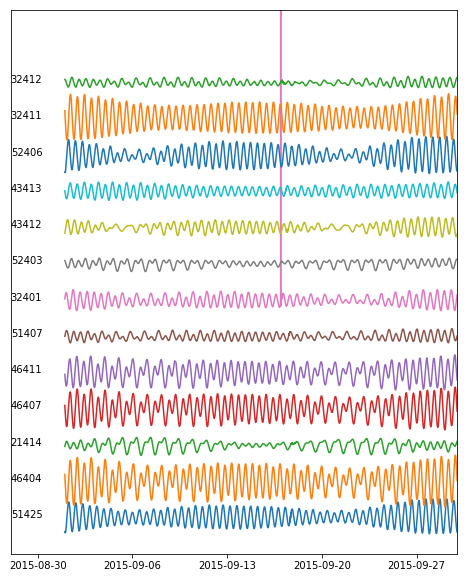

In [9]:
plt.figure(figsize=(8,10))
for i,dart in enumerate(DARTs):
    df = dataFrames[dart]
    plt.plot(df['height']-df['height'].mean()+i*2)
    plt.text(df.index.min()-pd.Timedelta(days=4),i*2,'{}'.format(dart))
    plt.ylim(-2,28)
    plt.xlim(df.index.min()-pd.Timedelta(days=4), df.index.max())
    plt.gca().set_yticks([])

# Apply high freq band filter

In [10]:
def interpolateToUniformStep(df2):
#     df = df2.iloc[np.where(1-np.isnan(df2))[0]]
    df = df2.dropna()
    t0 = df.index.to_julian_date()

    dt = np.unique(np.diff(t0[::-1]))[1:].min()
    #assuming dt in days need it in seconds
#     dt = max(dt, 0.1)
    
    t = np.arange(t0.min(),t0.max()+dt,dt)
    print('original tseries shape=',t.shape)
    npower2 = int(np.ceil(np.log2(t.shape[0])))
    t = np.linspace(t0.min(),t0.max(),2**npower2)
    dt = np.diff(t)[0]
    
    print('interpolating with dt = {} days  = {} seconds'.format(dt,dt*24*60*60))
    print('and shape = ',t.shape)

    h = np.interp(t,t0[::-1],df['height'][::-1])
    return dt, t,h

In [11]:
def filterSignal(h,cut,dt):
    
    print('taking fft of signal with shape:', h.shape)
    a = np.fft.fft(h)
    freq = np.fft.fftfreq(h.shape[0],d=dt)
    alow = np.where(np.abs(freq)<=cut,a,0.0)
    ahigh = np.where(np.abs(freq)>cut,a,0.0)
    print('getting low freq signal')
    hlow = np.fft.ifft(alow)
    print('getting high freq signal')
    hhigh = np.fft.ifft(ahigh)
    print('done')
    nonzerolow = np.where(np.abs(alow)>1e-5)[0]
    nonzerohigh = np.where(np.abs(ahigh)>1e-5)[0]
    lowSignal = {
        'a': alow[nonzerolow],
        'h': hlow,
        'freq': freq[nonzerolow]
    }
    
    highSignal = {
        'a': ahigh[nonzerohigh],
        'h': hhigh,
        'freq': freq[nonzerohigh]
    }
    return lowSignal, highSignal

In [12]:
def getFilteredSignal(df,cut):
    dt, t,h = interpolateToUniformStep(df)
    lowSignal, highSignal = filterSignal(h,cut,dt)
    return lowSignal, highSignal, t, h

In [13]:
filteredSignals = {}

In [14]:
threshold = {}
for key in dataFrames.keys():
    threshold[key] = 5

In [15]:
for key in dataFrames.keys():
    print('\n{}'.format(key))
    lowSignal,highSignal, t, h = getFilteredSignal(dataFrames[key], threshold[key])
    filteredSignals[key] = {
        'lowSignal': lowSignal,
        'highSignal': highSignal, 
        't': t, 
        'h': h
    }


51425
original tseries shape= (167042,)
interpolating with dt = 0.00011062668636441231 days  = 9.558145701885223 seconds
and shape =  (262144,)
taking fft of signal with shape: (262144,)
getting low freq signal
getting high freq signal
done

46404
original tseries shape= (167042,)
interpolating with dt = 0.00011062668636441231 days  = 9.558145701885223 seconds
and shape =  (262144,)
taking fft of signal with shape: (262144,)
getting low freq signal
getting high freq signal
done

21414
original tseries shape= (167042,)
interpolating with dt = 0.00011062668636441231 days  = 9.558145701885223 seconds
and shape =  (262144,)
taking fft of signal with shape: (262144,)
getting low freq signal
getting high freq signal
done

46407
original tseries shape= (167042,)
interpolating with dt = 0.00011062668636441231 days  = 9.558145701885223 seconds
and shape =  (262144,)
taking fft of signal with shape: (262144,)
getting low freq signal
getting high freq signal
done

46411
original tseries shape= (

In [16]:
dataFrames.keys()

dict_keys([51425, 46404, 21414, 46407, 46411, 51407, 32401, 52403, 43412, 43413, 52406, 32411, 32412])

In [17]:
map(lambda k: k, dataFrames.keys())


/home/jose/gitrepos/Nami/asdf/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


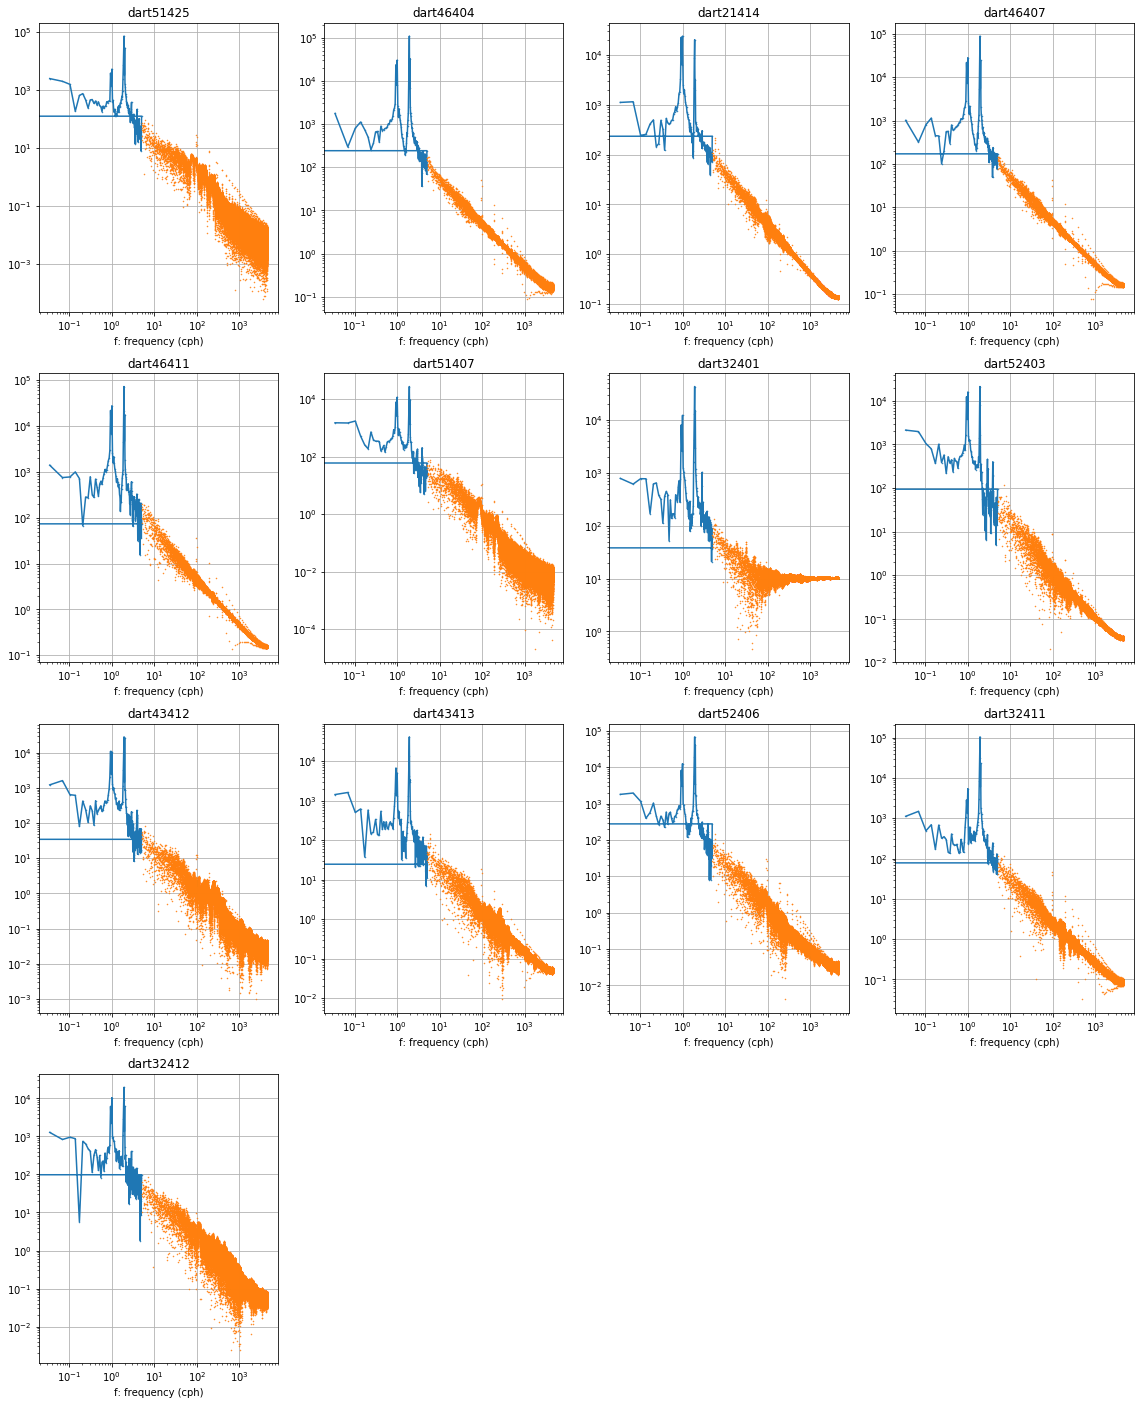

In [19]:
plt.figure(figsize=(16,12*2))
for i,dart in enumerate(list(DARTs)):

    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )

    plt.subplot(5,4,i+1)
    plt.plot(lowSignal['freq'][1:],np.abs(lowSignal['a'])[1:],'.-',ms=1)
    plt.plot(highSignal['freq'][1:],np.abs(highSignal['a'])[1:],'.',ms=1)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.grid('on')
    plt.xlabel('f: frequency (cph)')
    plt.title('dart{}'.format(dart))
#     plt.ylim(4,14)
plt.tight_layout()
plt.savefig('dart-spectra.png',dpi=300)

In [20]:
earthquakeDate = pd.to_datetime('2015-09-16 22:54:33')
tearthquake = earthquakeDate.to_julian_date()

[]

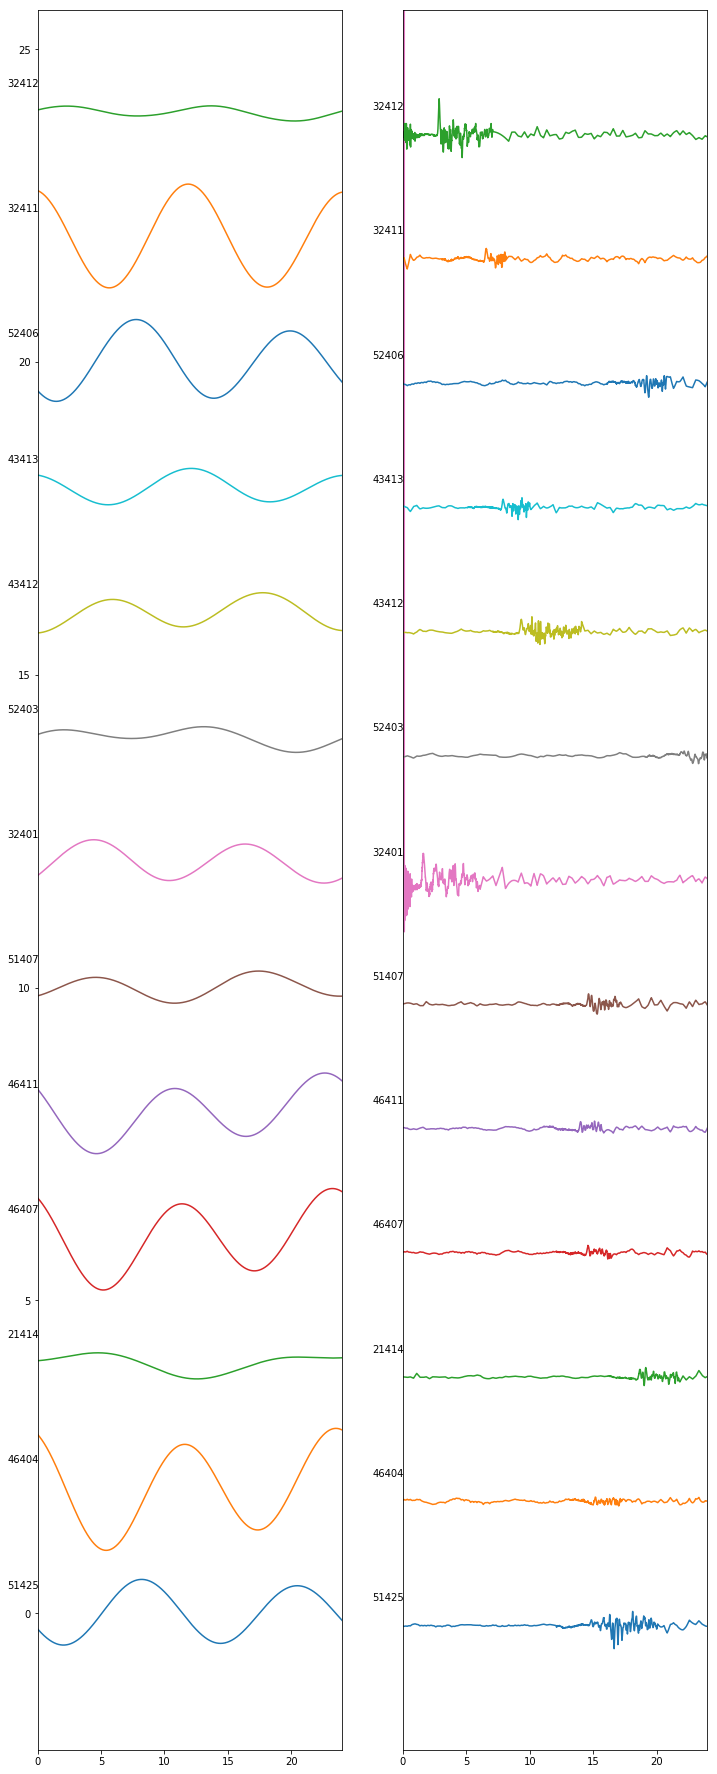

In [21]:
plt.figure(figsize=(12,32))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for i,dart in enumerate(DARTs):
    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )
    lowSignal['h'].real = lowSignal['h'].real - lowSignal['h'].real.mean() 
    df = dataFrames[dart]
    ax1.plot((t-tearthquake)*24,lowSignal['h'].real+i*2)
    ax2.plot((t-tearthquake)*24,highSignal['h'].real+i*0.25)
    
    ax1.text(-2.4, i*2+0.05*8, '{}'.format(dart))
    ax2.text(-2.4, i*0.25+0.05, '{}'.format(dart))
# plt.ylim(-2,10)
ax1.set_xlim(0,24)
ax2.set_xlim(0,24)
ax2.set_ylim(-1,len(DARTs)*2)
ax2.set_ylim(-1/4,len(DARTs)*0.25)

ax2.set_yticks([])
# plt.gca().get_yaxis().set_visible(False)

In [34]:
t-tearthquake

array([-15.95454861, -15.95443798, -15.95432736, ...,  13.04523014,
        13.04534076,  13.04545139])

In [40]:
highSignal

{'a': array([ 17.85819027+48.74115446j,   9.48313077+66.7039577j ,
        -15.54500952+36.75310361j, ..., -15.54500952-36.75310361j,
          9.48313077-66.7039577j ,  17.85819027-48.74115446j]),
 'h': array([-0.1153913 +3.95394980e-18j, -0.11514177+3.13537716e-17j,
        -0.11489182+4.44484774e-17j, ...,  0.11554241-1.52373180e-16j,
         0.11579064+1.71401776e-16j,  0.1160393 +7.00684712e-17j]),
 'freq': array([ 5.03446157,  5.06894418,  5.10342679, ..., -5.10342679,
        -5.06894418, -5.03446157])}

(-0.1, 0.1)

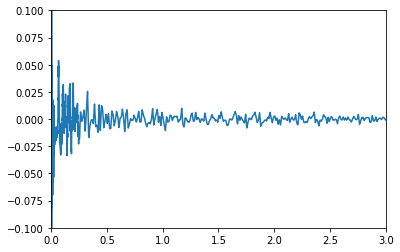

In [61]:
plt.plot(t-tearthquake,highSignal['h'].real)
plt.xlim(0.,3)
plt.ylim(-0.1,0.1)

In [35]:
for dart in [32401]:
    lowSignal,highSignal, t, h = (filteredSignals[dart]['lowSignal'],
                            filteredSignals[dart]['highSignal'],
                            filteredSignals[dart]['t'],
                            filteredSignals[dart]['h'] )
    
    fout = 'tsunamiDART{}.txt'.format(dart)
    print(fout)
    np.savetxt(fout,np.vstack([t-tearthquake,highSignal['h'].real]).T,delimiter=',', header='time,height')

tsunamiDART32401.txt


In [ ]:
plt.